In [59]:
import pandas as pd
import numpy as np
import geopandas as gpd

   OBJECTID                                             INDEX_  AGE_CODE  \
0       446  UNDIFF.FLUVIAL / AEOLIAN / COASTA & GLACIAL  S...        28   
1       505           ACID  INTRUSIVE / GRANITE / GRANODIORITE        43   
2       476                         BASIC VOLCANICS (HIMALAYA)        67   
3       473                         BASIC VOLCANICS (HIMALAYA)        67   
4       507           ACID  INTRUSIVE / GRANITE / GRANODIORITE        43   

          AGE SUPERGROUP GROUP_  GEOM_ID  \
0  QUATERNARY       None   None      289   
1    TERTIARY       None   None      439   
2    MESOZOIC       None   None      677   
3    MESOZOIC       None   None      677   
4    TERTIARY       None   None      439   

                                          STRATIGRAP  \
0  289,UNDIFF.FLUVIAL / AEOLIAN / COASTA & GLACIA...   
1  439,ACID  INTRUSIVE / GRANITE / GRANODIORITE,T...   
2            677,BASIC VOLCANICS (HIMALAYA),MESOZOIC   
3            677,BASIC VOLCANICS (HIMALAYA),MESOZOIC  

<Axes: >

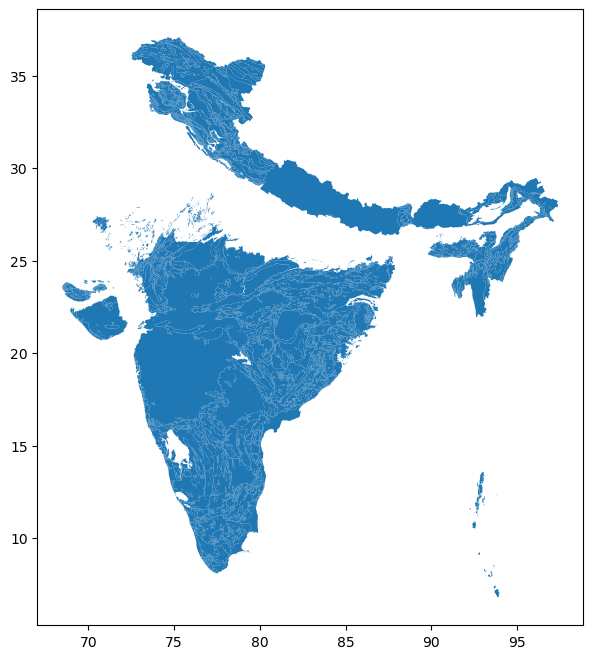

In [60]:
gdf = gpd.read_file("..\data\Soil Profiles\Geology\Geology 2M.shp")

print(gdf.head())
print(gdf.columns)
print(gdf.crs)

gdf.plot(figsize=(10, 8))


In [61]:

states = gpd.read_file("..\data\Soil Profiles\india_states\gadm41_IND_1.json").to_crs("EPSG:4326")
gdf = gdf.to_crs(states.crs)

print("Geology CRS:", gdf.crs)
print("States CRS:", states.crs)

Geology CRS: EPSG:4326
States CRS: EPSG:4326


In [62]:
gdf_states = gpd.sjoin(gdf, states, how="inner", predicate="intersects")

print(gdf_states.head())
print(gdf_states.columns)

    OBJECTID                             INDEX_  AGE_CODE  \
34       283  Undiff. Carboniferous-Permian fms        76   
35      3441           LADAKH GRANITOID COMPLEX        48   
39      3226                          SHYOK Gp.        35   
41      3229                         SALTRO Gp.        88   
42      3221             BIAGDONG VOLCANICS Fm.        48   

                       AGE SUPERGROUP  GROUP_  GEOM_ID  \
34  CARBONIFEROUS- PERMIAN       None    None      765   
35   CRETACEOUS - TERTIARY       None    None      486   
39        EOCENE - MIOCENE       None   SHYOK      354   
41              PALAEOZOIC       None  SALTRO      888   
42   CRETACEOUS - TERTIARY       None    None      487   

                                           STRATIGRAP  \
34  765,Undiff. Carboniferous-Permian fms,CARBONIF...   
35  486,LADAKH GRANITOID COMPLEX,CRETACEOUS - TERT...   
39                     354,SHYOK Gp.,EOCENE - MIOCENE   
41                          888,SALTRO Gp.,PALAEOZOIC   

In [63]:
states_ae = states.to_crs(7755).copy()
states_ae["geometry"] = states_ae.buffer(0)
states_diss = states_ae.dissolve(by="NAME_1", as_index=False)

# 1) project geology and intersect
geol_ae = gdf.to_crs(7755).copy()
inter = gpd.overlay(
    geol_ae[["AGE","SUPERGROUP","GROUP_","STRATIGRAP","geometry"]],
    states_diss[["NAME_1","geometry"]],
    how="intersection",
    keep_geom_type=False
)

# 3) area (km²)
inter = inter[inter.geometry.notnull() & ~inter.geometry.is_empty]
inter["area_km2"] = inter.geometry.area / 1e6

# 4) pick a geology descriptor (fallbacks)
desc = inter["GROUP_"].fillna(inter["SUPERGROUP"]).fillna(inter["AGE"])
inter["geo_class"] = desc.fillna("UNKNOWN")

# 5) summarize by state × geology
by_state_geo = (
    inter.groupby(["NAME_1","geo_class"], dropna=False)["area_km2"]
         .sum()
         .reset_index()
         .sort_values(["NAME_1","area_km2"], ascending=[True,False])
)

# 6) add % of state
state_area = (
    inter.groupby("NAME_1")["area_km2"]
         .sum()
         .rename("state_area_km2")
         .reset_index()
)
by_state_geo = by_state_geo.merge(state_area, on="NAME_1", how="left")
by_state_geo["pct_of_state"] = 100 * by_state_geo["area_km2"] / by_state_geo["state_area_km2"]

print(by_state_geo.head(20))

               NAME_1                       geo_class      area_km2  \
0   AndamanandNicobar                 ANDAMAN  FLYSCH   3046.465966   
1   AndamanandNicobar                      MITHAKHARI   1245.404224   
2   AndamanandNicobar                     ARCHIPELAGO   1221.303416   
3   AndamanandNicobar                         UNKNOWN    277.278209   
4   AndamanandNicobar            JURASSIC- CRETACEOUS    234.056571   
5   AndamanandNicobar             PALAEOCENE - EOCENE     61.515553   
6   AndamanandNicobar                      QUATERNARY     54.886419   
7   AndamanandNicobar                        CENOZOIC      5.885406   
8       AndhraPradesh  PENINSULAR GNEISSIC COMPLEX-II  47318.712932   
9       AndhraPradesh                      QUATERNARY  21728.639252   
10      AndhraPradesh                      NALLAMALAI  18927.916172   
11      AndhraPradesh                      KHONDALITE  12317.446002   
12      AndhraPradesh                       MIGMATITE  11777.816982   
13    

In [64]:
print(by_state_geo['NAME_1'].nunique())

35


In [65]:
# # predominant geology class per state (by area)
# idx = by_state_geo.groupby("NAME_1")["area_km2"].idxmax()
# predominant_geo = (by_state_geo.loc[idx, ["NAME_1","geo_class","area_km2","pct_of_state"]]
#                    .sort_values("NAME_1")
#                    .reset_index(drop=True))

# print(predominant_geo.head(20))
# print("States covered:", predominant_geo["NAME_1"].nunique())


In [66]:
# states_pred = states_diss[["NAME_1","geometry"]].merge(predominant_geo, on="NAME_1", how="left")
# ax = states_pred.plot(column="geo_class", legend=True, figsize=(10,10), edgecolor="black")
# ax.set_axis_off()


In [67]:
import re
import numpy as np
import pandas as pd

# build a rich description + keep AGE separate
text_cols = ["GROUP_", "SUPERGROUP", "INDEX_", "STRATIGRAP", "AGE"]
for c in text_cols:
    if c not in inter.columns: inter[c] = ""
inter["DESC"] = inter[text_cols].fillna("").astype(str).agg(" ".join, axis=1).str.upper()
inter["AGE_UP"] = inter["AGE"].fillna("").str.upper()

# regex helpers that don't match SANDSTONE when we mean sand
pat_sand   = re.compile(r"\bSAND(S|Y)?\b|\bBEACH SAND\b|\bCOASTAL SAND\b")
pat_gravel = re.compile(r"GRAVEL|PEBBLE|COBBLE")
pat_alluv  = re.compile(r"ALLUVI|FLUVIAL|VALLEY FILL|FLOODPLAIN|DELTA|ESTUAR|LACUSTRINE|DUNE|AEOLIAN|EOLIAN")

def classify_perm4_row(age, desc):
    # 1) High
    if any(k in age for k in ["QUATERNARY","HOLOCENE","PLEISTOCENE","RECENT"]):
        return "high"
    if pat_alluv.search(desc) or pat_sand.search(desc) or pat_gravel.search(desc):
        return "high"
    # 2) Moderate
    if any(k in desc for k in ["SANDSTONE","CONGLOMERATE","SILTSTONE","LIMESTONE","DOLOMITE","FLYSCH","TIPAM","SURMA","SIWALIK",
                                "BHANDER","AJABGARH","RAIPUR","CRETACEOUS - TERTIARY","EOCENE","MIOCENE","PALEOCENE","OLIGOCENE"]):
        return "moderate"
    # 3) Low
    if any(k in desc for k in ["SHALE","CLAY","MUDSTONE","SLATE","MARL","BASALT","TRAP","VOLCAN"]):
        return "low"
    # 4) Very low
    if any(k in desc for k in ["GRANITE","GRANITO","GNEISS","SCHIST","CHARNOC","MIGMAT","CRYSTALLINE","PENINSULAR",
                               "BUNDELKHAND","CHHOTANAGPUR","CENTRAL CRYSTALLINE","VAIKRITA","LOHIT"]):
        return "very_low"
    return "moderate"

inter["perm4"] = [classify_perm4_row(a, d) for a, d in zip(inter["AGE_UP"], inter["DESC"])]

# summarize and pick predominant category per state
by_state_perm = (inter.groupby(["NAME_1","perm4"])["area_km2"].sum().reset_index())
state_tot = by_state_perm.groupby("NAME_1")["area_km2"].sum().rename("state_area_km2")
by_state_perm = by_state_perm.merge(state_tot, on="NAME_1", how="left")
by_state_perm["pct_of_state"] = 100 * by_state_perm["area_km2"] / by_state_perm["state_area_km2"]

idx = by_state_perm.groupby("NAME_1")["area_km2"].idxmax()
pred_perm = (by_state_perm.loc[idx, ["NAME_1","perm4","pct_of_state"]]
             .rename(columns={"perm4":"predominant_perm"})
             .sort_values("NAME_1"))

print(by_state_perm["perm4"].value_counts())
print(pred_perm['predominant_perm'].value_counts())


perm4
moderate    34
high        32
very_low    24
low         13
Name: count, dtype: int64
predominant_perm
moderate    20
very_low    12
high         3
Name: count, dtype: int64


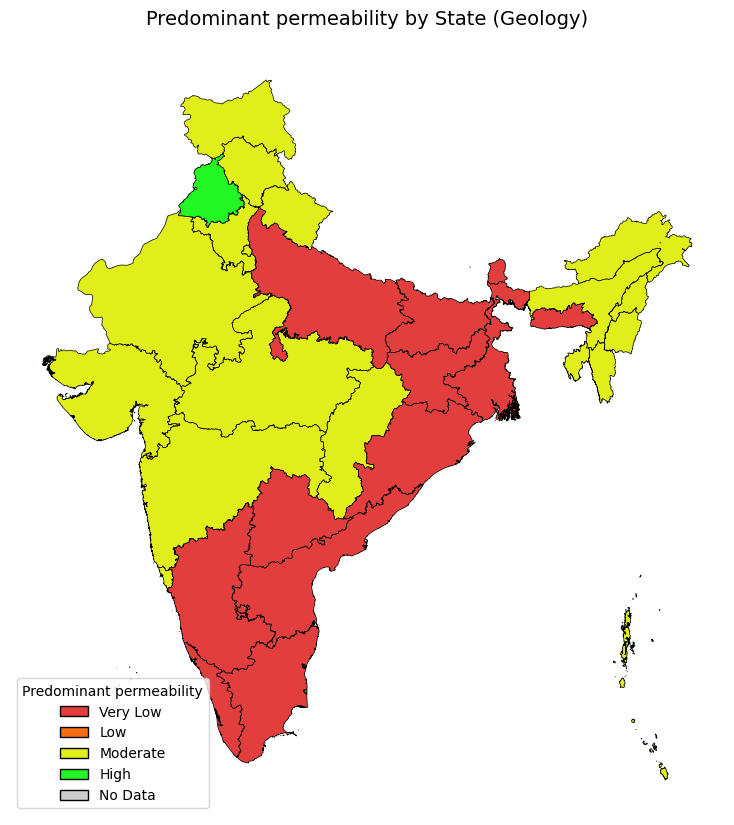

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


states_pred = states_diss[["NAME_1","geometry"]].merge(pred_perm, on="NAME_1", how="left")

perm_order = ["very_low","low","moderate","high"]
color_map = {
    "very_low": "#e23e3e",
    "low":      "#f36c12",
    "moderate": "#e0ee1a",
    "high":     "#23f723",
    "no_data":  "#cccccc"
}

states_pred["predominant_perm"] = states_pred["predominant_perm"].fillna("no_data")
states_pred["color"] = states_pred["predominant_perm"].map(color_map)

fig, ax = plt.subplots(figsize=(10,10))
states_pred.plot(ax=ax, color=states_pred["color"], edgecolor="black", linewidth=0.5)

ax.set_title("Predominant permeability by State (Geology)", fontsize=14, pad=15)
ax.set_axis_off()

handles = [Patch(facecolor=color_map[k], edgecolor="black", label=k.replace("_"," ").title())
           for k in perm_order + ["no_data"]]
ax.legend(handles=handles, title="Predominant permeability", loc="lower left")
plt.show()

In [74]:
states_pred.head()

,NAME_1,geometry,predominant_perm,pct_of_state,color
0,AndamanandNicobar,"MULTIPOLYGON (((5.56e+06 2.19e+06, 5.56e+06 2....",moderate,99.011325,#e0ee1a
1,AndhraPradesh,"MULTIPOLYGON (((4.16e+06 3.17e+06, 4.16e+06 3....",very_low,54.212521,#e23e3e
2,ArunachalPradesh,"POLYGON ((5.49e+06 4.42e+06, 5.49e+06 4.42e+06...",moderate,89.784570,#e0ee1a
3,Assam,"POLYGON ((5.27e+06 4.11e+06, 5.27e+06 4.11e+06...",moderate,62.389220,#e0ee1a
4,Bihar,"MULTIPOLYGON (((4.6e+06 4.1e+06, 4.6e+06 4.1e+...",very_low,55.928730,#e23e3e


In [75]:
states_pred[['NAME_1', 'predominant_perm', 'pct_of_state']].to_csv("../data/predominant_permeability_by_state.csv", index=False)